<a href="https://colab.research.google.com/gist/Leo-Sun-BMSTU/68fc6c9c87872a9c948850ec4e00975f/lw1-lw2wind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Лабораторная работа №1.Метод ближайших соседей**

Подключение библиотек 📖📚


In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загрузка данных ⬇️

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/SolarPrediction.csv')
data.head(10)

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00
5,1475227824,9/29/2016 12:00:00 AM,23:30:24,1.21,48,30.46,64,120.20,5.62,06:13:00,18:13:00
6,1475227519,9/29/2016 12:00:00 AM,23:25:19,1.20,49,30.46,72,112.45,6.75,06:13:00,18:13:00
7,1475227222,9/29/2016 12:00:00 AM,23:20:22,1.24,49,30.46,71,122.97,5.62,06:13:00,18:13:00
8,1475226922,9/29/2016 12:00:00 AM,23:15:22,1.23,49,30.46,80,101.18,4.50,06:13:00,18:13:00
9,1475226622,9/29/2016 12:00:00 AM,23:10:22,1.21,49,30.46,85,141.87,4.50,06:13:00,18:13:00


In [ ]:
data.shape

(32686, 11)

# Информационная справка
📉

In [ ]:
data.info()
print()
data.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB



Index(['UNIXTime', 'Data', 'Time', 'Radiation', 'Temperature', 'Pressure',
       'Humidity', 'WindDirection(Degrees)', 'Speed', 'TimeSunRise',
       'TimeSunSet'],
      dtype='object')

Набор данных представляет собой климатические параметры.🌦 В основном данные числовые, данных типа object🛸 не много. Будем предсказывать значение переменной WindDirection(Degrees) - направление ветра💨, нас будет интересовать южный📊

Удаление неинформативных признаков 🗑❌

In [ ]:
data = data.drop(['UNIXTime', 'Data', 'Time', 'TimeSunRise', 'TimeSunSet'], axis='columns')

In [ ]:
data.columns

Index(['Radiation', 'Temperature', 'Pressure', 'Humidity',
       'WindDirection(Degrees)', 'Speed'],
      dtype='object')

Переименование столбцов как принято в Data Science - в едином регистре и с символом _ вместо пробелов🤓


In [ ]:
data.set_axis(['radiation', 'temperature', 'pressure', 'humidity', 'wind_direction(degrees)', 'speed'], axis='columns', inplace=True)
data.columns

Index(['radiation', 'temperature', 'pressure', 'humidity',
       'wind_direction(degrees)', 'speed'],
      dtype='object')

In [ ]:
data.head(5)

,radiation,temperature,pressure,humidity,wind_direction(degrees),speed
0,1.21,48,30.46,59,177.39,5.62
1,1.21,48,30.46,58,176.78,3.37
2,1.23,48,30.46,57,158.75,3.37
3,1.21,48,30.46,60,137.71,3.37
4,1.17,48,30.46,62,104.95,5.62


Изменение порядка столбцов, чтобы целевой признак оказался крайним правым в таблице♻️

In [ ]:
cols = list(data.columns)
a, b = cols.index('wind_direction(degrees)'), cols.index('speed')
cols[b], cols[a] = cols[a], cols[b]
data = data[cols]
data

,radiation,temperature,pressure,humidity,speed,wind_direction(degrees)
0,1.21,48,30.46,59,5.62,177.39
1,1.21,48,30.46,58,3.37,176.78
2,1.23,48,30.46,57,3.37,158.75
3,1.21,48,30.46,60,3.37,137.71
4,1.17,48,30.46,62,5.62,104.95
...,...,...,...,...,...,...
32681,1.22,44,30.43,102,6.75,145.42
32682,1.17,44,30.42,102,6.75,117.78
32683,1.20,44,30.42,102,9.00,145.19
32684,1.23,44,30.42,101,7.87,164.19


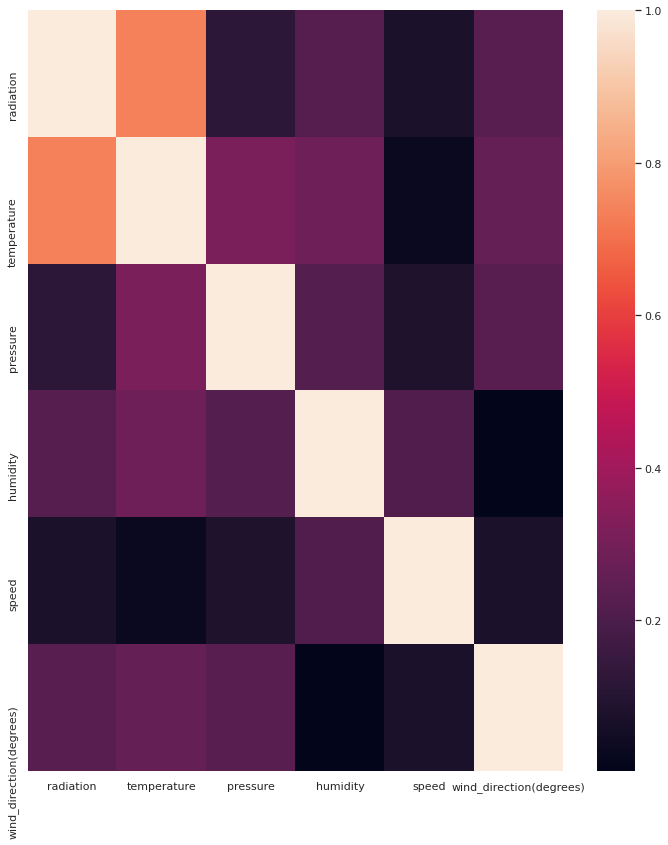

In [ ]:
import seaborn as sns
corr = data.corr().abs()
sns.set(rc={'figure.figsize':(12, 14)})
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Видно что признак "radiation"☢️ довольно сильно коррелирует с "temperature"🌡, поэтому удалим его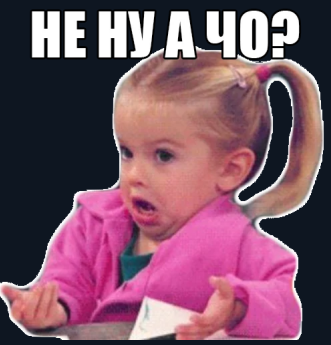

In [ ]:
data = data.drop('radiation', axis='columns')

In [ ]:
data.dtypes 

temperature                  int64
pressure                   float64
humidity                     int64
speed                      float64
wind_direction(degrees)    float64
dtype: object

Проверка наличия значений NaN 🤔

In [ ]:
data.isna().any()

temperature                False
pressure                   False
humidity                   False
speed                      False
wind_direction(degrees)    False
dtype: bool

In [ ]:
Max = max(data['wind_direction(degrees)'])
Min = min(data['wind_direction(degrees)'])
print(Max, Min)

359.95 0.09


Разделим направление ветра на 2 класса: южный☀️ (присвоим ему значение 1) и северный❄️ ветер (значение 0)

In [ ]:
counts = data['wind_direction(degrees)']
for i in range(len(counts)):
     if counts[i] < 90 or counts[i] > 315:
       counts[i] = 0
     else:
       counts[i] = 1
print(counts)   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
32681    1.0
32682    1.0
32683    1.0
32684    1.0
32685    0.0
Name: wind_direction(degrees), Length: 32686, dtype: float64


# **Machine Learning**💪😎
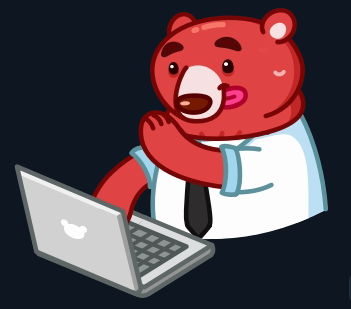

Выделение целевой переменной и разделение выборки на тренировочную и тестовую

In [ ]:
from sklearn import preprocessing
from sklearn import utils

X = data[data.columns[:4]]  
y = data['wind_direction(degrees)']
X = X.astype(np.int64, copy=False)
y = y.astype(np.int64, copy=False)
    
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
X

,temperature,pressure,humidity,speed
0,48,30,59,5
1,48,30,58,3
2,48,30,57,3
3,48,30,60,3
4,48,30,62,5
...,...,...,...,...
32681,44,30,102,6
32682,44,30,102,6
32683,44,30,102,9
32684,44,30,101,7


In [ ]:
y_test

2408     0
10205    0
1231     0
10847    1
32260    1
        ..
3978     1
18017    1
22063    1
9974     1
18525    1
Name: wind_direction(degrees), Length: 6538, dtype: int64

Создание модели классификатора на основе метода ближайших соседей (kNN) 👀

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# создание классификатора
clf = KNeighborsClassifier(n_neighbors = 5)
# обучение
clf.fit(X_train, y_train)
# доля верных результатов алгоритма
clf.score(X_test, y_test)

0.7990211073722852

Предсказание классов для объектов из тестовой выборки🔮

In [ ]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)
#y_pred
y_pred_proba[:, 0]

array([1. , 0.8, 1. , ..., 1. , 0. , 0.6])

In [ ]:
y_pred

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
X_test

,temperature,pressure,humidity,speed
2408,58,30,86,4
10205,48,30,102,3
1231,62,30,78,5
10847,50,30,102,1
32260,45,30,93,4
...,...,...,...,...
3978,50,30,98,6
18017,51,30,88,5
22063,63,30,45,7
9974,47,30,101,4


Влияние гиперпараметра (количество соседей) на качество классификации 📈📉

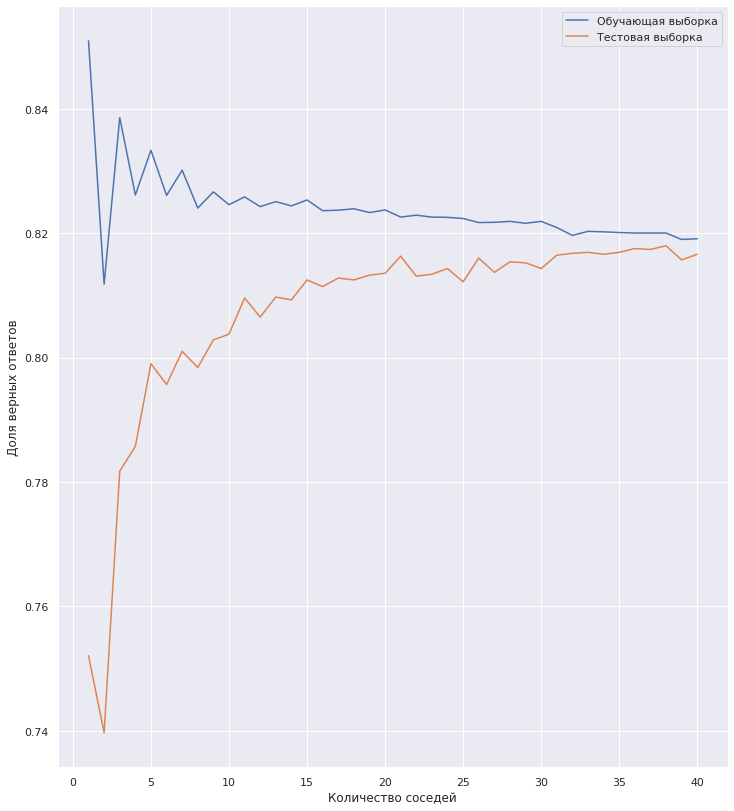

In [ ]:
train_scores = {}
test_scores = {}

# для n в диапазоне от 1 до 40 включительно
for n in range(1, 41):
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(X_train, y_train)
    # значение качества на текущей итерации:
    current_train_score = clf.score(X_train, y_train)
    current_test_score = clf.score(X_test, y_test)
    # запишем его в наши словари
    train_scores[n] = current_train_score
    test_scores[n] = current_test_score

#train_scores = train_scores.astype(np.int32, copy=False)

# нарисуем графики

plt.plot(list(train_scores.keys()), list(train_scores.values()), label='Обучающая выборка')
plt.plot(list(test_scores.keys()), list(test_scores.values()), label='Тестовая выборка')
plt.xlabel('Количество соседей')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# **Вывод:** для данной задачи оптимальное число соседей 21 👌
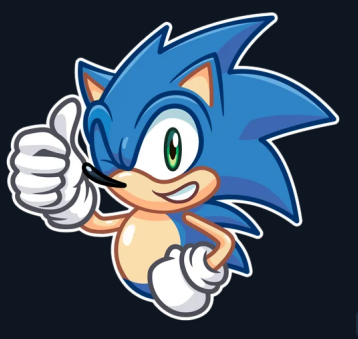

# **Лабораторная работа №2. Разведочный анализ данных** 🔍

# Структура данных 🧱

Распределение данных отсносительно друг друга 🤝

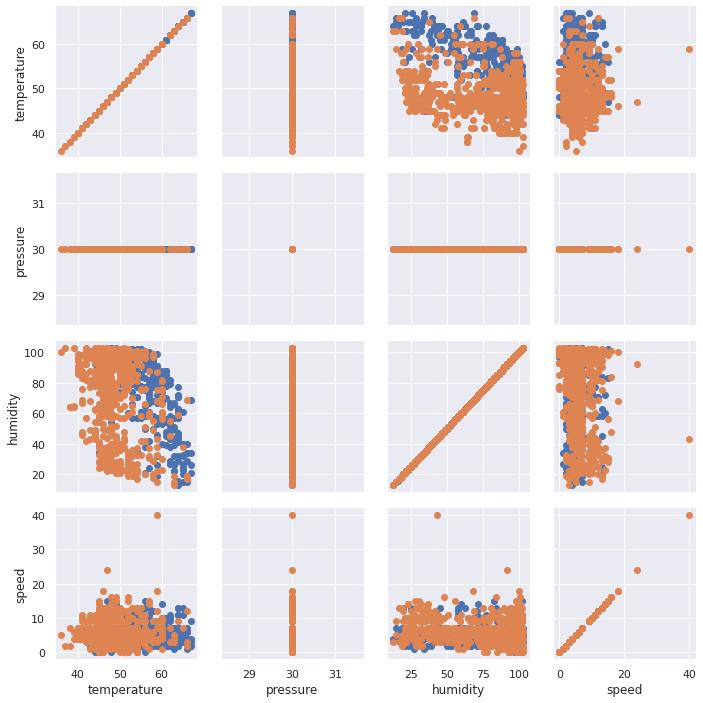

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)   #stratify=y

df_for_pairgrid = X_train[['temperature', 'pressure', 'humidity', 'speed']]
df_for_pairgrid['wind_direction(degrees)'] = y_train

sns.PairGrid(df_for_pairgrid[:1000], hue='wind_direction(degrees)').map(plt.scatter)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24514 entries, 4453 to 8235
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   temperature  24514 non-null  int64
 1   pressure     24514 non-null  int64
 2   humidity     24514 non-null  int64
 3   speed        24514 non-null  int64
dtypes: int64(4)
memory usage: 957.6 KB


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   temperature              32686 non-null  int64  
 1   pressure                 32686 non-null  float64
 2   humidity                 32686 non-null  int64  
 3   speed                    32686 non-null  float64
 4   wind_direction(degrees)  32686 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 1.2 MB


Расспредление конкретных признаков 📣

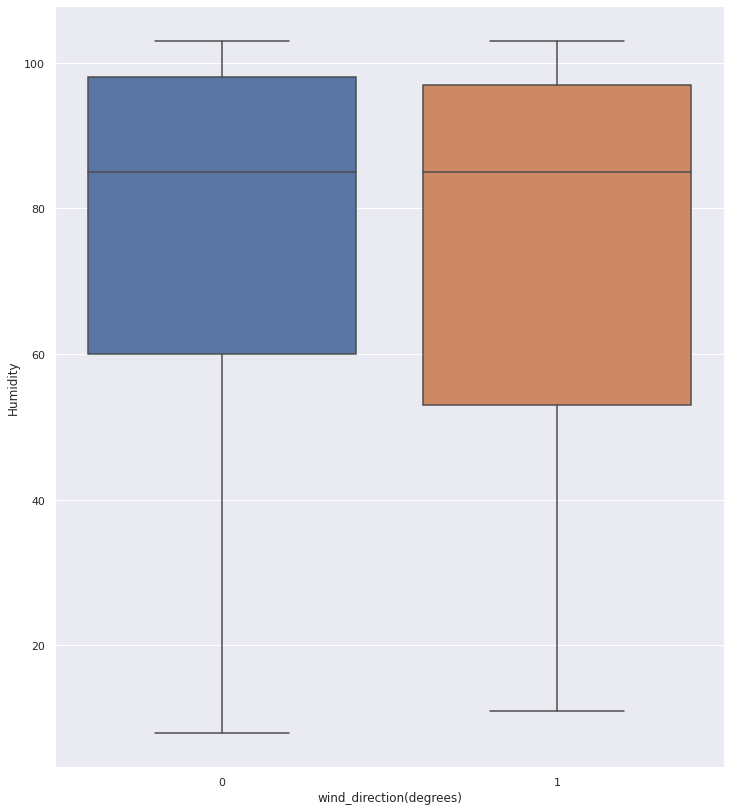

In [ ]:
Humidity = pd.read_csv('/content/drive/My Drive/Colab Notebooks/SolarPrediction.csv', sep=',')['Humidity'].apply(lambda x: x if x >= 0 else x / 5000)
sns.boxplot(x=y, y=Humidity)

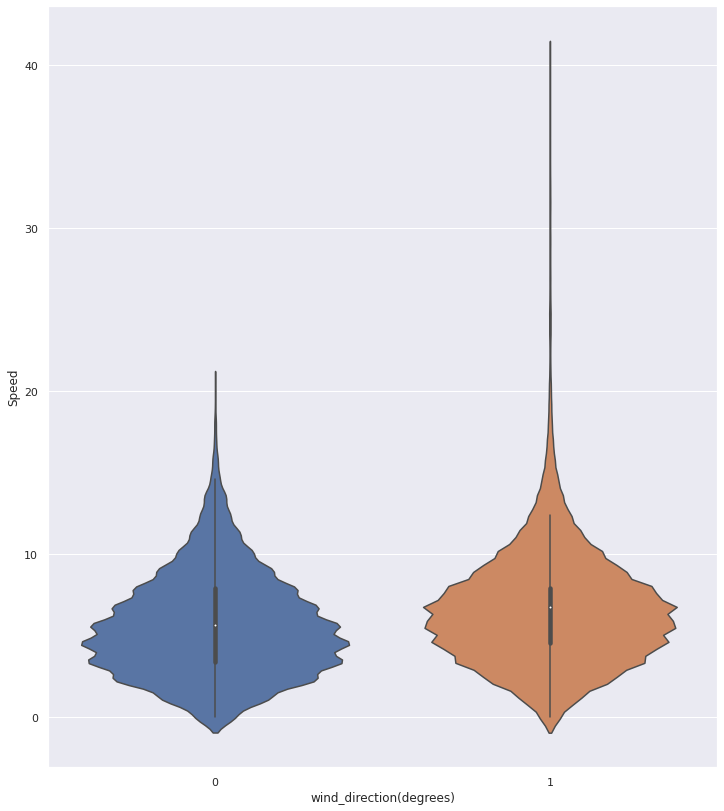

In [ ]:
Speed = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SolarPrediction.csv', sep=',')['Speed'].apply(lambda x: x if x >= 0 else x /5000)
sns.violinplot(x=y, y=Speed)

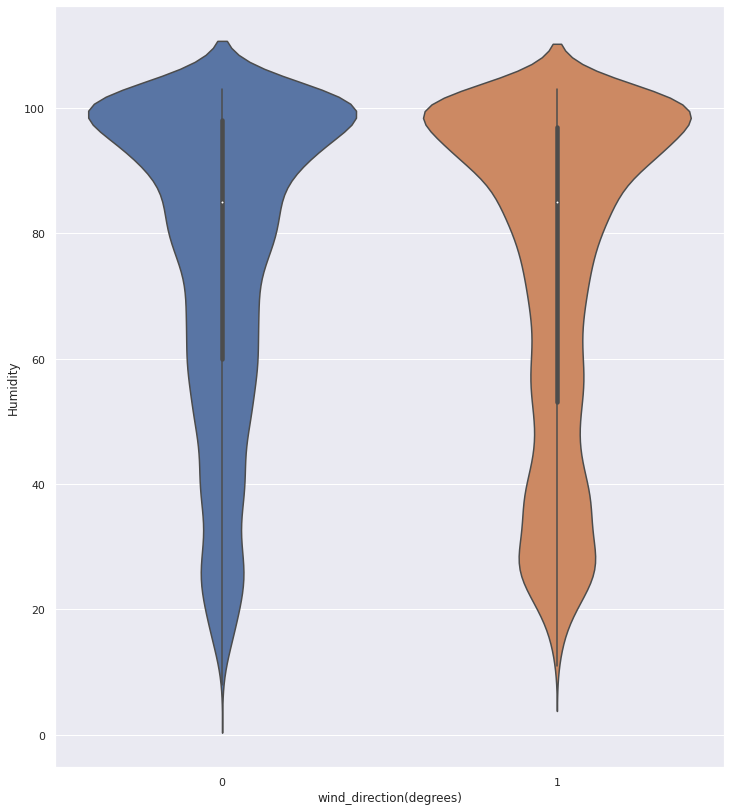

In [ ]:
Humidity = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SolarPrediction.csv', sep=',')['Humidity'].apply(lambda x: x if x >= 0 else x /5000)
sns.violinplot(x=y, y=Humidity)

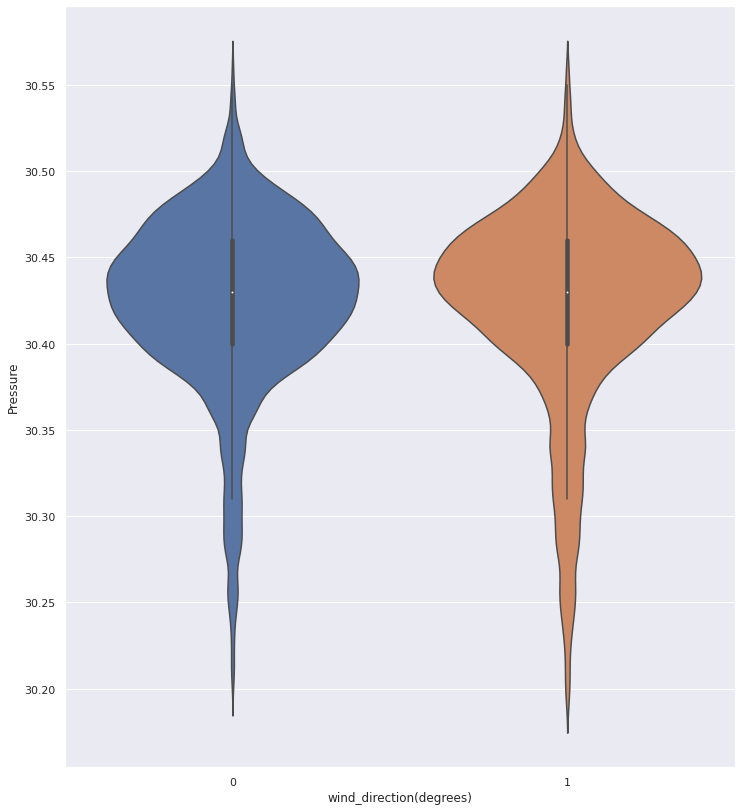

In [ ]:
Pressure = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SolarPrediction.csv', sep=',')['Pressure'].apply(lambda x: x if x >= 0 else x /5000)
sns.violinplot(x=y, y=Pressure)

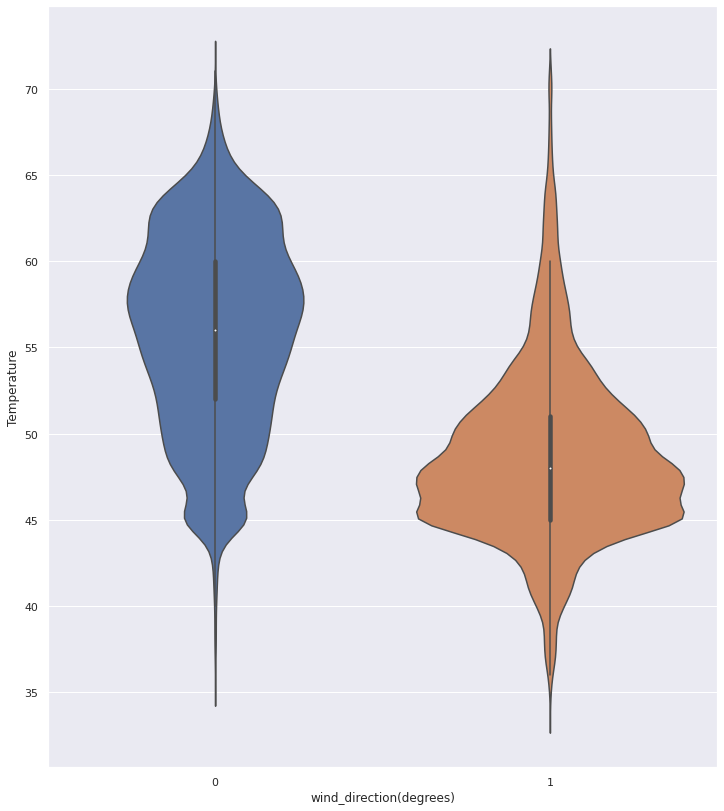

In [ ]:
Temperature = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SolarPrediction.csv', sep=',')['Temperature'].apply(lambda x: x if x >= 0 else x /5000)
sns.violinplot(x=y, y=Temperature)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24514 entries, 4453 to 8235
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   temperature  24514 non-null  int64
 1   pressure     24514 non-null  int64
 2   humidity     24514 non-null  int64
 3   speed        24514 non-null  int64
dtypes: int64(4)
memory usage: 957.6 KB


In [ ]:
X_train['speed'].value_counts()

5     3440
4     3413
6     3170
3     2900
7     2694
2     2107
9     1897
10    1284
1     1011
11     819
12     516
0      377
13     337
14     184
15     112
16      65
18      43
19      22
20      21
24      13
23      12
22       8
25       8
27       8
21       7
28       7
29       7
32       7
30       6
31       6
33       4
34       3
37       2
38       2
36       1
40       1
Name: speed, dtype: int64

In [ ]:
X_train

,temperature,pressure,humidity,speed
4453,52,30,76,2
1798,60,30,82,6
10529,47,30,101,5
96,59,30,46,3
15338,49,30,97,6
...,...,...,...,...
24416,56,30,35,4
15998,51,30,102,3
330,52,30,67,6
30600,49,30,102,1


# Нормализация 🤏

Качество алгоритма до нормализации: 0.7387420460107684
Качество алгоритма после нормализации: 0.7446157611355849


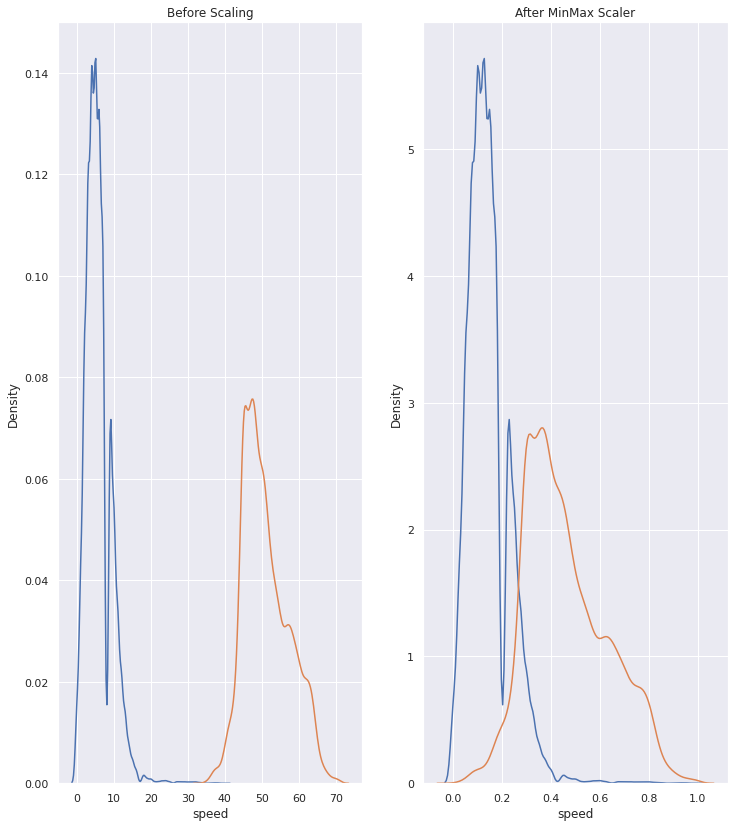

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

print("Качество алгоритма до нормализации:",
      KNeighborsClassifier(n_neighbors=2).fit(X_train, y_train).score(X_test, y_test))

scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train, ), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

print("Качество алгоритма после нормализации:",
      KNeighborsClassifier(n_neighbors=2).fit(X_train_scaled, y_train).score(X_test_scaled, y_test))

# графики
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.set_title('Before Scaling')
sns.kdeplot(X_train['speed'], ax=ax1)
sns.kdeplot(X_train['temperature'], ax=ax1)
ax2.set_title('After MinMax Scaler')
sns.kdeplot(X_train_scaled['speed'], ax=ax2)
sns.kdeplot(X_train_scaled['temperature'], ax=ax2)
plt.show()

# Подбор оптимальной модели 🥇

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

for clf in [DecisionTreeClassifier(), SGDClassifier(), SVC(), GaussianNB(), KNeighborsClassifier()]:
    print(clf.__class__.__name__, clf.fit(X_train_scaled, y_train).score(X_test_scaled, y_test))

DecisionTreeClassifier 0.7722711698482624
SGDClassifier 0.7825501713166911
SVC 0.8158345570239843
GaussianNB 0.8055555555555556
KNeighborsClassifier 0.8018844836025453


**Вывод: метод kNN неплох, но для данной задачи не оптимален**

In [ ]:
X_train_scaled

,temperature,pressure,humidity,speed
0,0.486486,0.0,0.715789,0.050
1,0.702703,0.0,0.778947,0.150
2,0.351351,0.0,0.978947,0.125
3,0.675676,0.0,0.400000,0.075
4,0.405405,0.0,0.936842,0.150
...,...,...,...,...
24509,0.594595,0.0,0.284211,0.100
24510,0.459459,0.0,0.989474,0.075
24511,0.486486,0.0,0.621053,0.150
24512,0.405405,0.0,0.989474,0.025


# Стратификация

Распределение классов в тренировочной выборке

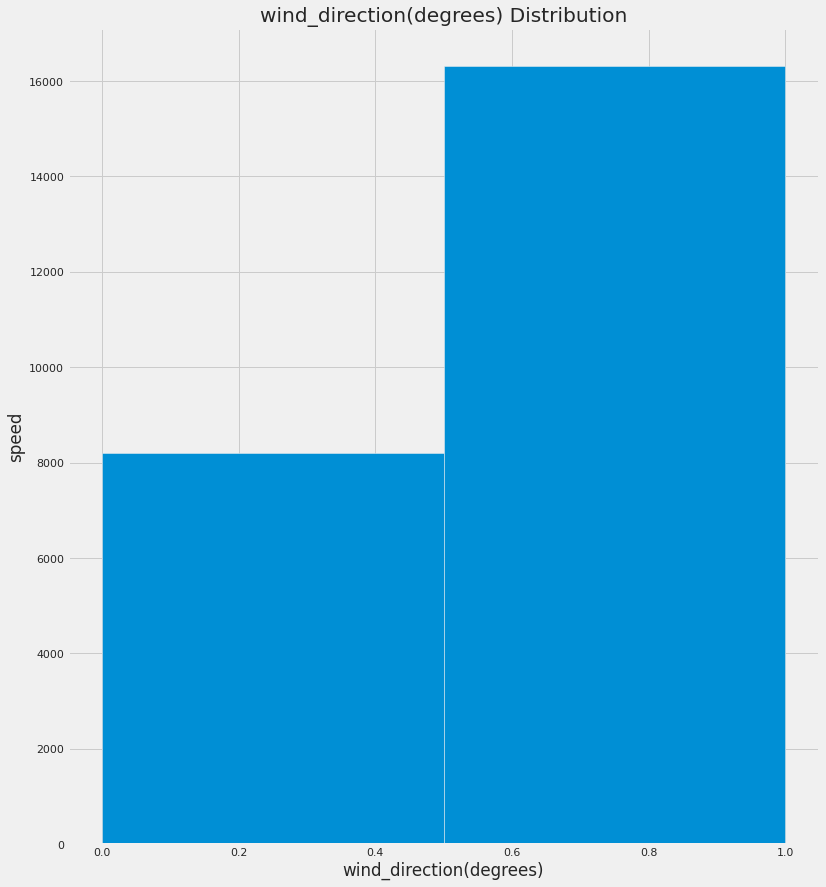

In [ ]:
plt.style.use('fivethirtyeight')
plt.hist(y_train, bins=2);
plt.xlabel('wind_direction(degrees)'); plt.ylabel('speed');
plt.title('wind_direction(degrees) Distribution');

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test[:6538], y_pred)

0.558427653716733

Увеличение количества примеров из недоминантого класса

In [ ]:
X_train_scaled.reset_index(inplace=True, drop=True)
y_train.reset_index(drop=True, inplace=True)

In [ ]:
dead = X_train_scaled[y_train == 0]
X_train_strat = pd.concat([X_train_scaled, dead, dead], ignore_index=True)
y_train_strat = pd.concat([y_train, pd.Series(np.ones(X_train_strat.shape[0]-X_train_scaled.shape[0]))],
                          ignore_index=True)

In [ ]:
for clf in [DecisionTreeClassifier(), SGDClassifier(), SVC(), GaussianNB(), KNeighborsClassifier()]:
    print(clf.__class__.__name__, clf.fit(X_train_strat, y_train_strat).score(X_test_scaled, y_test))

DecisionTreeClassifier 0.666421928536466
SGDClassifier 0.666421928536466
SVC 0.666421928536466
GaussianNB 0.666421928536466
KNeighborsClassifier 0.6680127263827704


# Метрики качества

ROC & PRC для логистической регрессии

training accuracy : 0.8034592477767806
testing accuracy : 0.8034752814488497
ROC-AUC: 0.868


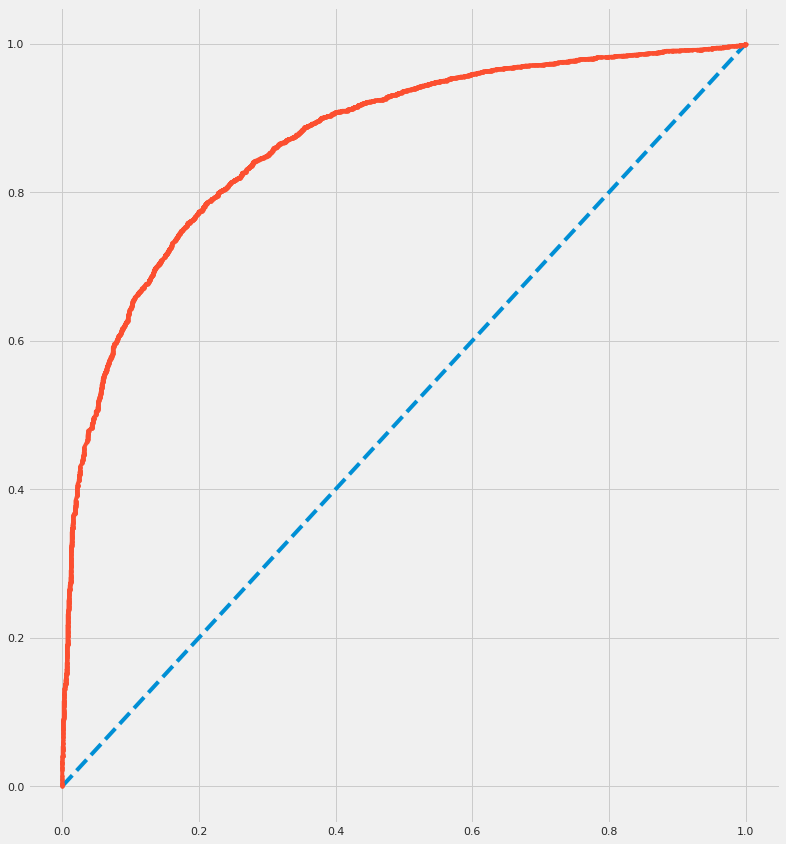


PR-AUC:    0.9277618590879939


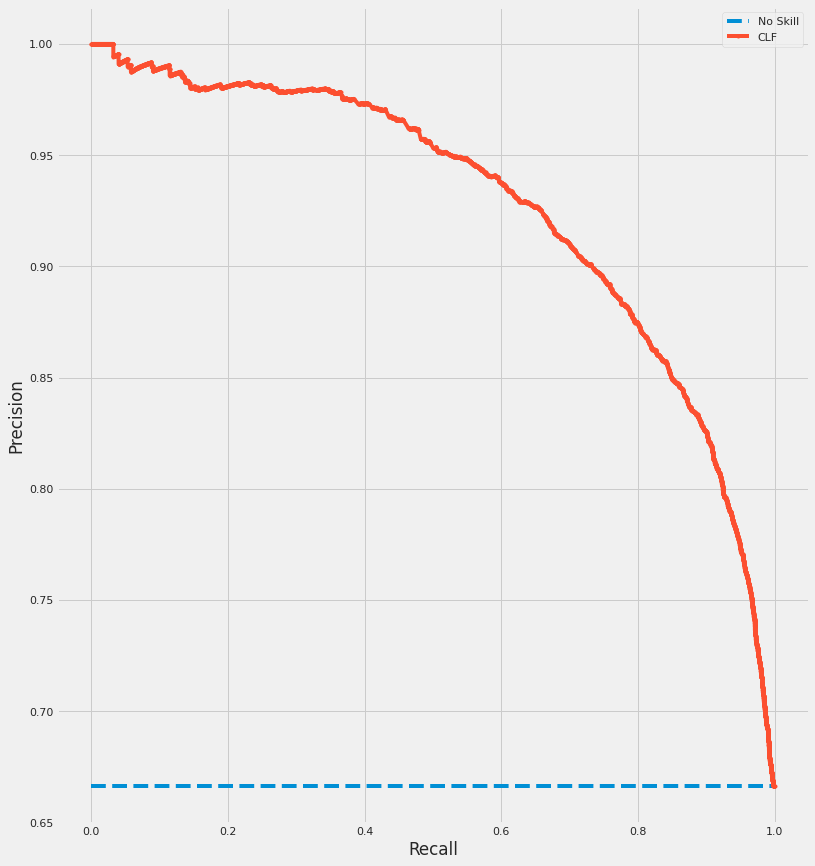

Accuracy: 0.558427653716733
Precision: 0.6814200092208391
Recall: 0.6626316969289398
F1: 0.6718945334697125
F0.5: 0.677577591344611
F2: 0.6663060138851321


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import roc_auc_score, f1_score, fbeta_score, auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import auc

model = LogisticRegression()
model.fit(X_train_scaled, y_train)
Y_pred = model.predict(X_test_scaled)
print("training accuracy :", model.score(X_train_scaled, y_train))
print("testing accuracy :", model.score(X_test_scaled, y_test))

#ROC-AUC

# predict probabilities
probs = model.predict_proba(X_test_scaled)
#Y_test==1
probs = probs[:, 1]
# calculate AUC
auc_1=roc_auc_score(y_test, probs)
print('ROC-AUC: %.3f' % auc_1)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

print()

#PR-AUC

pr,rec,_= precision_recall_curve(y_test, probs)
auc_2=auc(rec, pr)
print('PR-AUC:   ',auc_2)
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(rec, pr, marker='.', label='CLF')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()


print('Accuracy:', accuracy_score(y_pred, y_test[:6538]))
print('Precision:', precision_score(y_pred, y_test[:6538]))
print('Recall:', recall_score(y_pred, y_test[:6538]))
print('F1:', f1_score(y_pred, y_test[:6538]))
print('F0.5:', fbeta_score(y_pred, y_test[:6538], 0.5))
print('F2:', fbeta_score(y_pred, y_test[:6538], 2))


# ROC и PRC для метода ближайших соседей

training accuracy : 0.8323407032715999
testing accuracy : 0.8018844836025453
ROC-AUC: 0.847


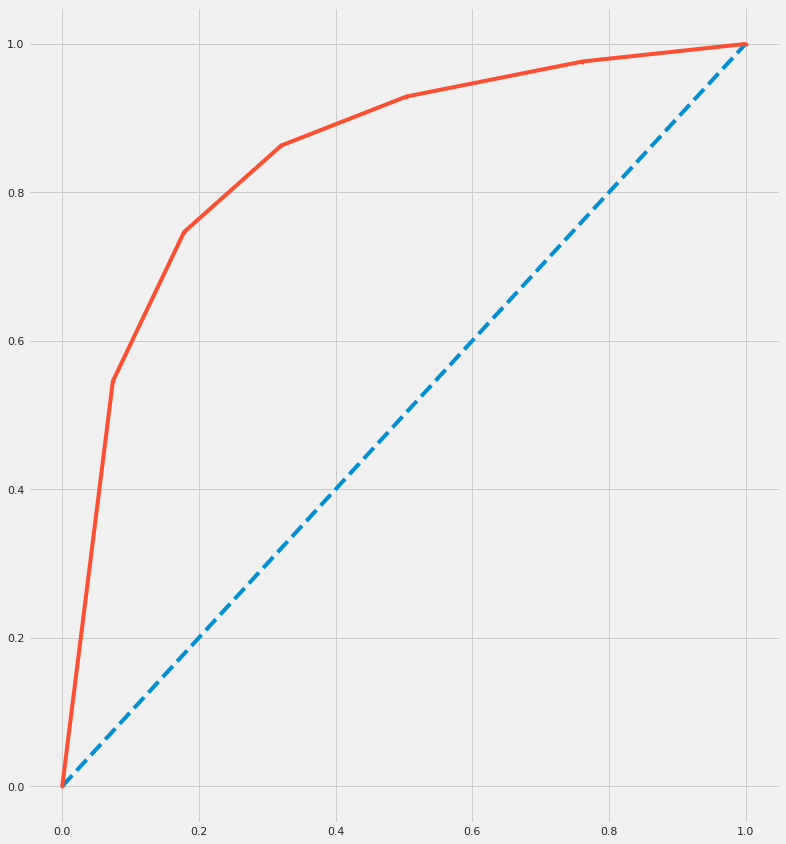


PR-AUC:    0.9190179201524055


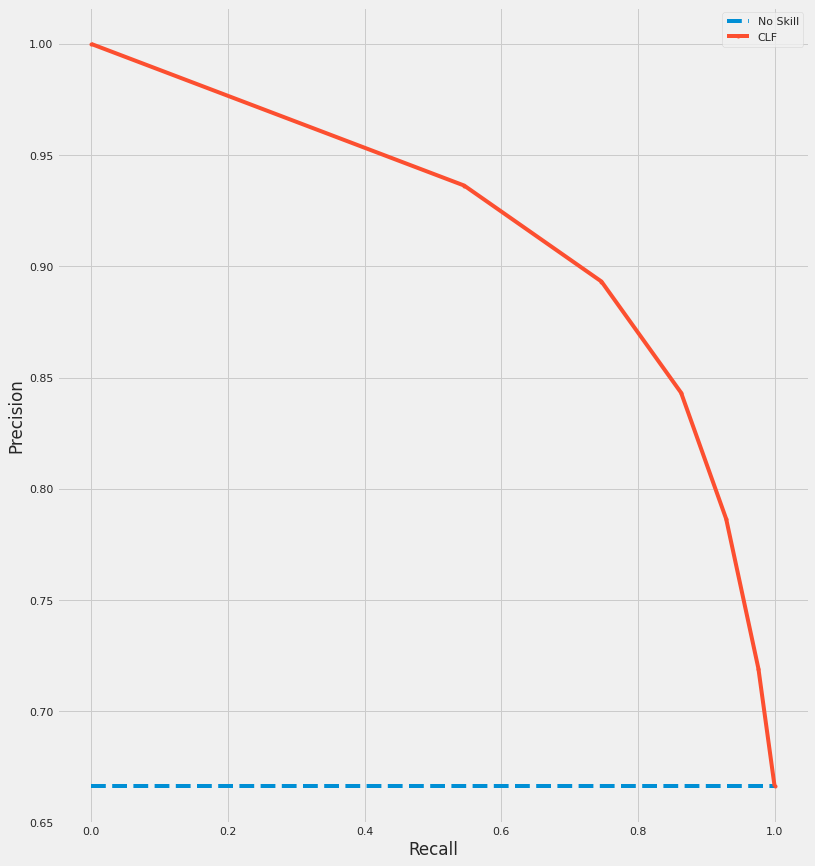

Accuracy: 0.8018844836025453
Precision: 0.8632023503488799
Recall: 0.8432286995515695
F1: 0.8530986298883949
F0.5: 0.8591322782265435
F2: 0.8471491386145751


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
print("training accuracy :", model.score(X_train_scaled, y_train))
print("testing accuracy :", model.score(X_test_scaled, y_test))

#ROC-AUC

# predict probabilities
probs = model.predict_proba(X_test_scaled)
#Y_test==1
probs = probs[:, 1]
# calculate AUC
auc_1=roc_auc_score(y_test, probs)
print('ROC-AUC: %.3f' % auc_1)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

print()

#PR-AUC

pr,rec,_=precision_recall_curve(y_test, probs)
auc_2=auc(rec, pr)
print('PR-AUC:   ',auc_2)
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(rec, pr, marker='.', label='CLF')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()


print('Accuracy:', accuracy_score(y_pred, y_test))
print('Precision:', precision_score(y_pred, y_test))
print('Recall:', recall_score(y_pred, y_test))
print('F1:', f1_score(y_pred, y_test))
print('F0.5:', fbeta_score(y_pred, y_test, 0.5))
print('F2:', fbeta_score(y_pred, y_test, 2))


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, roc_auc_score, f1_score, fbeta_score, auc

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred_proba[:, 1].round()))
print('Recall:', recall_score(y_test, y_pred_proba[:, 1].round()))
print('ROC AUC:', roc_auc_score(y_test, y_pred_proba[:, 1]))
pr, rec, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
print('PRC AUC:', auc(rec, pr))
print('F1:', f1_score(y_test, y_pred_proba[:, 1].round()))
print('F0.5:', fbeta_score(y_test, y_pred_proba[:, 1].round(), 0.5))
print('F2:', fbeta_score(y_test, y_pred_proba[:, 1].round(), 2))

Accuracy: 0.8018844836025453
Precision: 0.6626316969289398
Recall: 0.6814200092208391
ROC AUC: 0.4960919359570812
PRC AUC: 0.727827009777078
F1: 0.6718945334697125
F0.5: 0.6663060138851321
F2: 0.677577591344611


In [ ]:
y_pred_proba.shape

(6538, 2)

In [ ]:
y_test.shape

(8172,)

**Вывод:** "Accuracy" показало, что классификатор вполне не плохо справялется с задачей, доля верных ответов 0.8 😏 Однако, данную метрику нельзя считать достоверной, так как диаграмма распределения классов показывает доминирование одного над другим📊 Также не плоха и доля верных ответов ("Precision") среди всех объектов классифицированных как южный ветер - 0.66👍 Среди всех верно предсказанных объектов, объекты класса "южный ветер" составляют 68% ("Recall" = 0.68)🔥 Метод "PR curve" показал результат лучше чем "ROC", в силу дисбаланса классов, а по его свойствам PRC, он может работать качественно именно при этом условии📶 Если баланс изменится, то и PRC изменится🤷‍♂️ ROC кривая довольно далеко от диагонали, а значит классификатор даёт не случайные ответы💪 F-метрикик показали, что если отдавать предподчтение Recall, доля верных ответов выше⬆️ 
Итог: для данной задачи лучше использовать метрику Recall, а для вероятностной оценки использовать PRC кривую
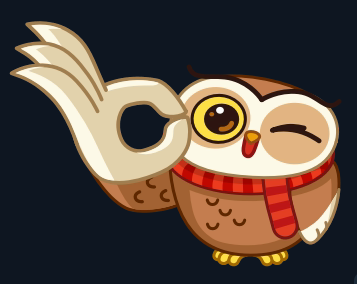